# Machine Failure Classification

**Context:** Missing

<br>

**Goal:** The dataset is used to predict whatever a machine will fail (1) or not (0). 

<br>

**Feature Description:**
- Missing

<br>

**Resources:**
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e17/overview)
- [Original Dataset](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions)

In [1]:
# Import Standard Libraries
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [5]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    data = pd.read_csv('', index_col=0)
    original_data = pd.read_csv('', index_col=0)
    
else:
    
    # Define local data file paths
    train_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E17' / 'machine_failure_classification_train.csv'
    test_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E17' / 'machine_failure_classification_test.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E17' / 'machine_failure_classification_original.csv'
   
    # Read data with Pandas DataFrame
    train_data = pd.read_csv(train_data_file_path, index_col=0)
    test_data = pd.read_csv(test_data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path, index_col=0)

In [6]:
train_data.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 136429 entries, 0 to 136428
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Product ID               136429 non-null  object 
 1   Type                     136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Machine failure          136429 non-null  int64  
 8   TWF                      136429 non-null  int64  
 9   HDF                      136429 non-null  int64  
 10  PWF                      136429 non-null  int64  
 11  OSF                      136429 non-null  int64  
 12  RNF                      136429 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 14.6+ MB


# Exploratory Data Analysis (EDA)

In [8]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [9]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (136429, 13)
- Original Data  -> (10000, 13)
- Test Data      -> (90954, 12)



## Null Values Information

In [10]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 0
- Original Data  -> 0
- Test Data      -> 0



No null values to fill. Good news!

## Feature Distribution

### Numerical Feature Distribution

In [11]:
# Define raw numerical features
raw_numerical_features = ['Air temperature [K]', 
                          'Process temperature [K]', 
                          'Rotational speed [rpm]', 
                          'Torque [Nm]', 
                          'Tool wear [min]', 
                          'TWF', 
                          'HDF', 
                          'PWF', 
                          'OSF', 
                          'RNF']

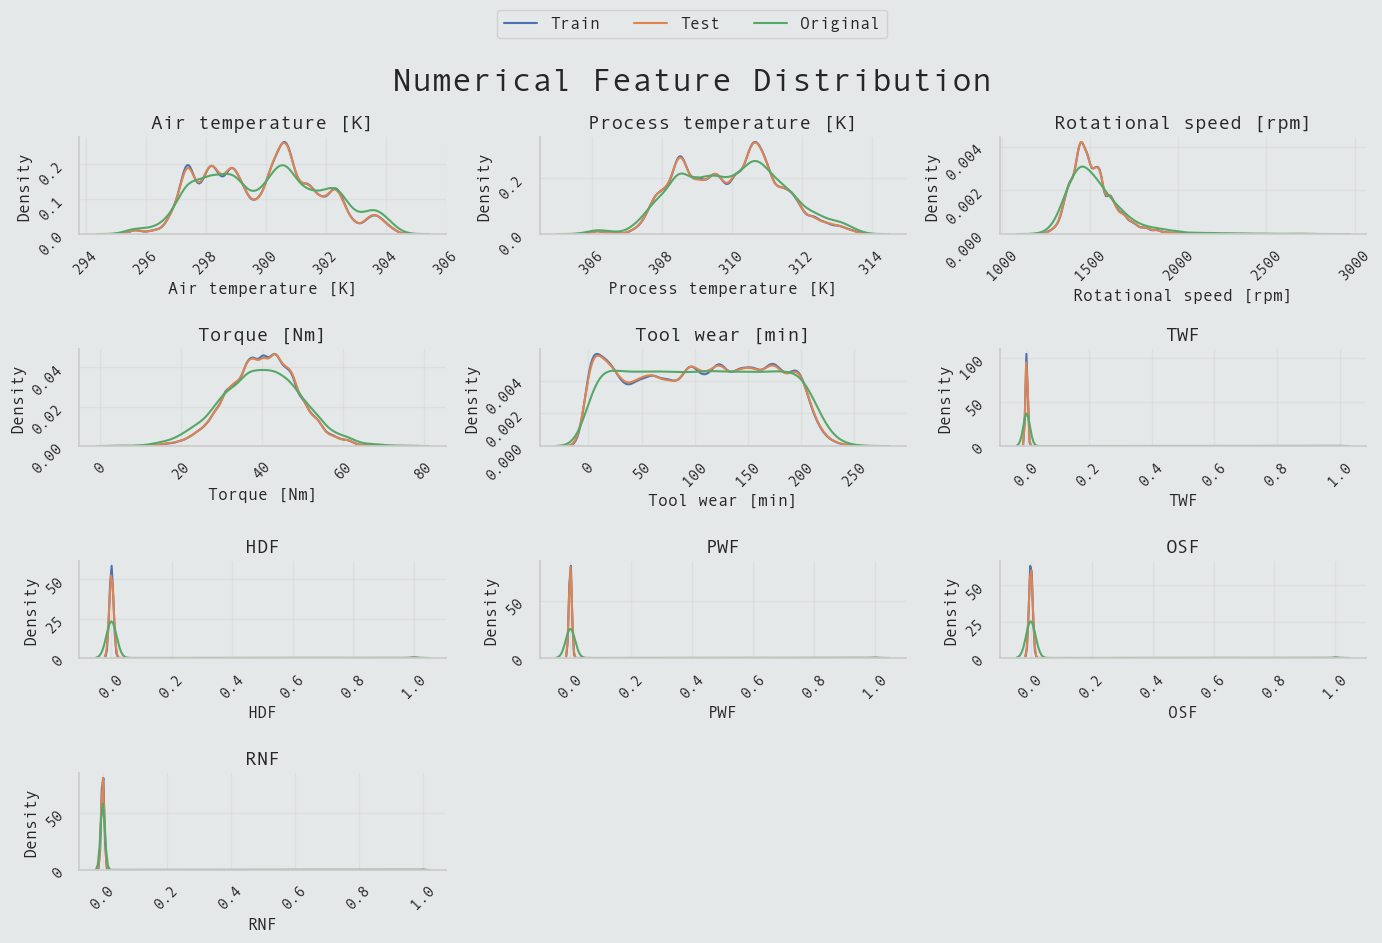

In [12]:
# Plot the KDE of each feature
figure, ax = plt.subplots(4, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplot
figure.delaxes(ax[-2])
figure.delaxes(ax[-1])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

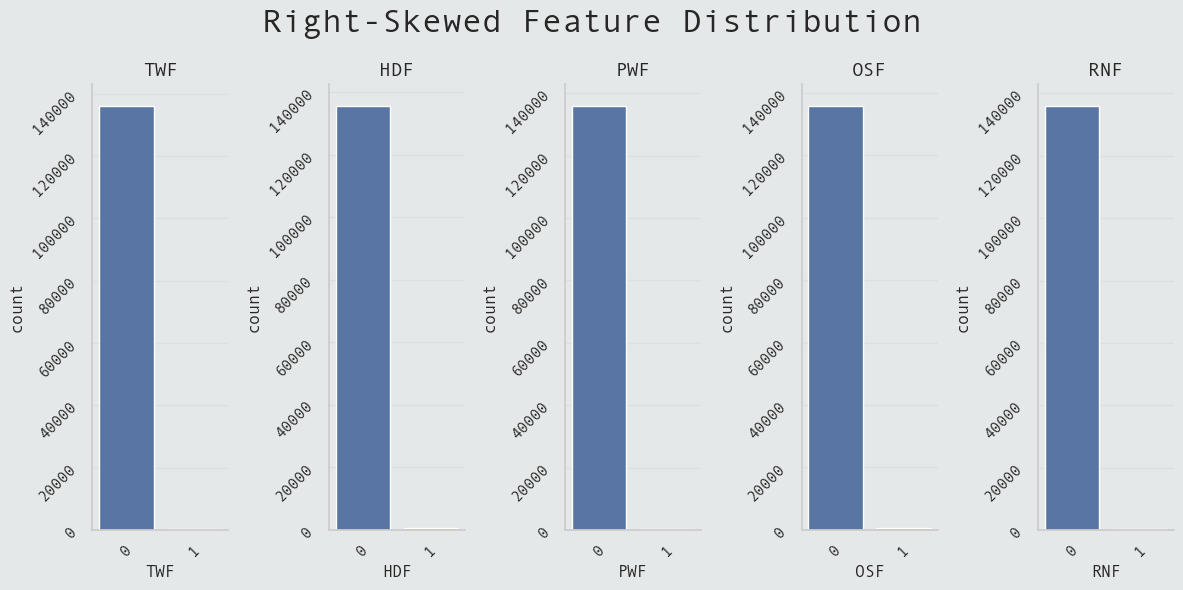

In [31]:
# Plot the Histogram for the last 5 features
figure, ax = plt.subplots(1, 5, figsize=(12, 6))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features[-5:]):
    
    # Plot data
    sns.countplot(data=train_data,
                  x=column_name,
                  ax=ax[index])
        
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
# Set figure Title
figure.suptitle('Right-Skewed Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- The following features are boolean values with a strong unbalancing: `TWF`, `HDF`, `PWF`, `OSF`, `RNF`
- Other features except `TWF`, `HDF`, `PWF`, `OSF`, `RNF` need to be scaled (Data Standardization)

### Categorical Feature Distribution

#### Product ID

In [21]:
# Print null values information
print(f"{blue}Product IDs:"
      f"{blue}\n- Train Data     -> {red}{train_data['Product ID'].nunique()}"
      f"{blue}\n- Original Data  -> {red}{original_data['Product ID'].nunique()}"
      f"{blue}\n- Test Data      -> {red}{test_data['Product ID'].nunique()}\n")

Product IDs:
- Train Data     -> 9976
- Original Data  -> 10000
- Test Data      -> 9909



A bit too high cardinality to have any reasonable plot.

#### Type

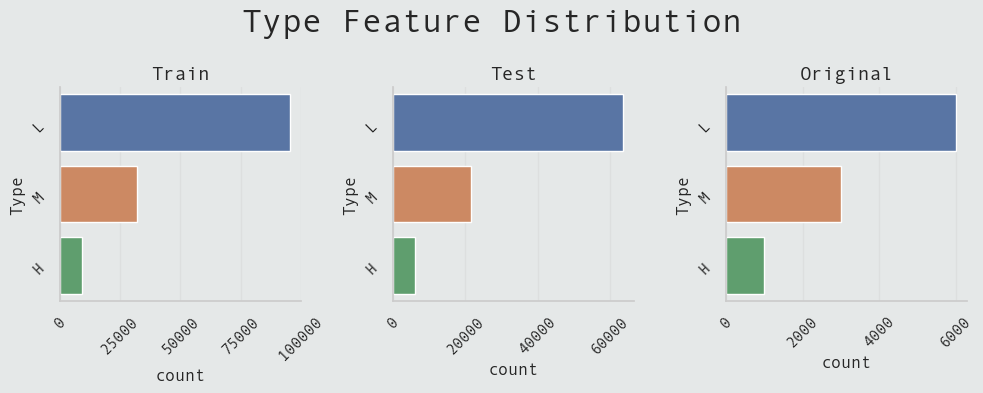

In [26]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(1, 3, figsize=(10, 4))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='Type',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['Type'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Type Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

Strong imbalance in the feature distribution. Might be useful to include it as a feature.

## Numerical Feature Distribution per Type

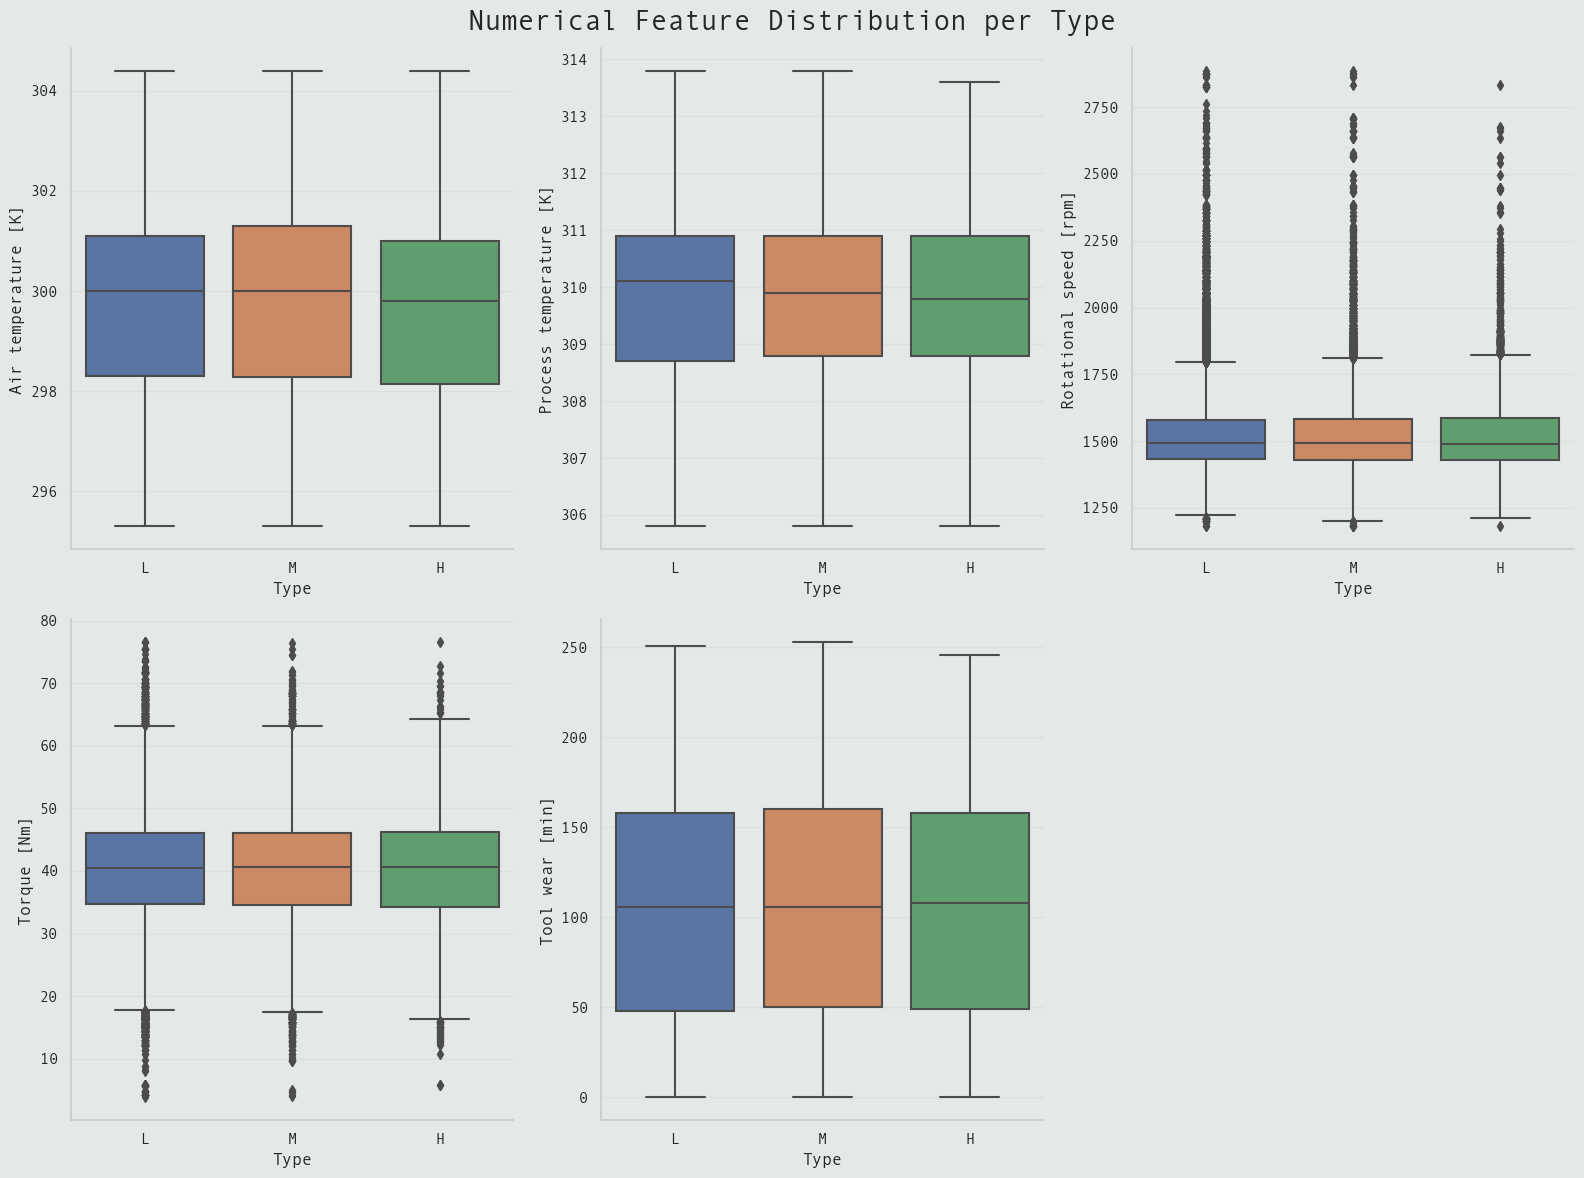

In [30]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features[:5]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='Type',
                y=column_name,
                ax=ax[index])
    
        
# Remove the empty subplot
figure.delaxes(ax[-1])

# Set figure Title
figure.suptitle('Numerical Feature Distribution per Type',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

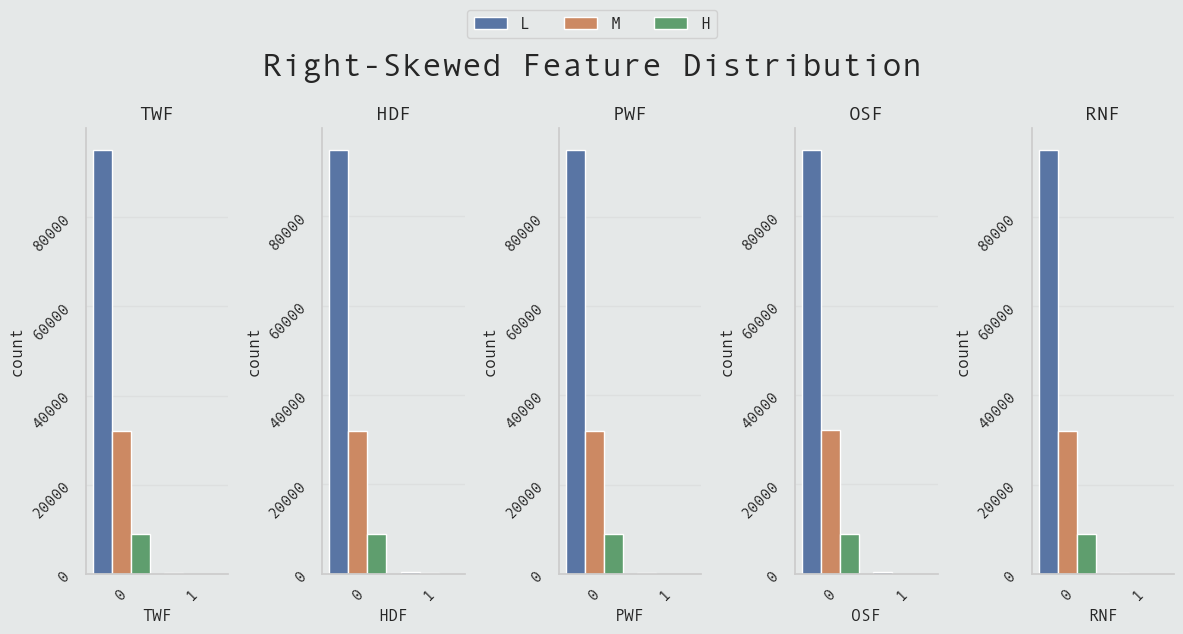

In [33]:
# Plot the Histogram for the last 5 features
figure, ax = plt.subplots(1, 5, figsize=(12, 6))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features[-5:]):
    
    # Plot data
    sns.countplot(data=train_data,
                  x=column_name,
                  hue='Type',
                  ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
        
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)
    
# Set figure Title
figure.suptitle('Right-Skewed Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- Though the `Type` feature does not have an impact on the first 5 numerical features, it does have on the boolean five. Let's include it as a feature.